Copying codes from William's notebook to do some exploration

In [2]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pickle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import time


#Set up a cosmology


cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



In [5]:
def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def z_chi(chi):
    return 1/ccl.scale_factor_of_chi(cosmo, chi)-1

def r_3d_rp(rp,z1,z2):
    return ((chi(z1)-chi(z2))**2+(rp)**2)**0.5

def xi_m(r,z):
    return ccl.correlations.correlation_3d(cosmo,a=1/(1+z),r=r,p_of_k_a='delta_matter:delta_matter')

In [6]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

Xi_3d=np.zeros((len(Zlist), len(R3d)),dtype=np.float64)
for iz in range(len(Zlist)):
    for ir in range(len(R3d)):
        Xi_3d[iz][ir]=xi_m(R3d[ir],Zlist[iz])

Xi_3d = np.savetxt('xi3d_estimator_z2_3_logrm1_p2.5.txt', Xi_3d)

In [7]:
Xi_3d=np.loadtxt('xi3d_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d=np.transpose(Xi_3d)

XI_interp=[]
for iz in range(len(Zlist)):
    XI_interp.append(interpolate.interp1d(R3d, Xi_3d[iz]))

print(np.shape(R3d), ' points for rp and ',np.shape(Zlist), ' for z')


print('minimal distance', round(R3d[0],4), 'Mpc and maximal ', round(R3d[-1],2),'Mpc')
print('minimal redshift', Zlist[0], ' and maximal ', round(Zlist[-1],2))

(40,)  points for rp and  (200,)  for z
minimal distance 0.1 Mpc and maximal  316.23 Mpc
minimal redshift 2.0  and maximal  3.0


In [8]:
# find the best indices with dichotomy

def find_r(x):
    arr=R3d
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

def find_z(x):
    arr=Zlist
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

In [9]:
def wnotLimber(zmean,Delta_z, rp): # Here we assume tophat n(z), much faster than the following function

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1) # find the best z-index for xi
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

def wnotLimber_n(z_array,nz1,nz2, rp): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
   rp the comoving perp distance in Mpc
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals
    '''

    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]
    
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        #xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts
            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta(zmean,Delta_z, theta_arcmin): #again, top hat n(z).
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean)
    

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1)
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2)
            
            if r<0.11:
                return 0
            if r>300:
                return 0
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta_n(z_array,nz1,nz2, theta_arcmin): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
    theta_arcmin the angular separation in arcmin.
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals.
    '''
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1[iz+1]!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]

    #print('range ',zmin,zmax)
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        rp=theta_rad*ra_cosmo(z1)
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
        
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]



In [10]:
def wLimber(zmean,Delta_z, rp): 

    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    
def wLimber_theta(zmean,Delta_z, theta_arcmin): #return eta+ for a bin centred in z with width Delta_z
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg


    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    

In [11]:
a=time.time()
print('w=',wnotLimber(2.5,0.1, 5))
print(round(time.time(),3)-a,' seconds')

a=time.time()
print('w=',wnotLimber(2.5,0.1, 50))
print(round(time.time(),3)-a,' seconds')

print('large scales are much faster to evaluate!')

w= 0.03703926428834724
9.673442602157593  seconds
w= 0.0019598660146792454
0.8243062496185303  seconds
large scales are much faster to evaluate!


In [12]:
rp=5
Dz=0.025
zmean=2.5
(wLimber(zmean,Dz, rp)-wnotLimber(zmean,Dz, rp))/wLimber(zmean,Dz, rp)

0.12069968127684445

# Below RSD

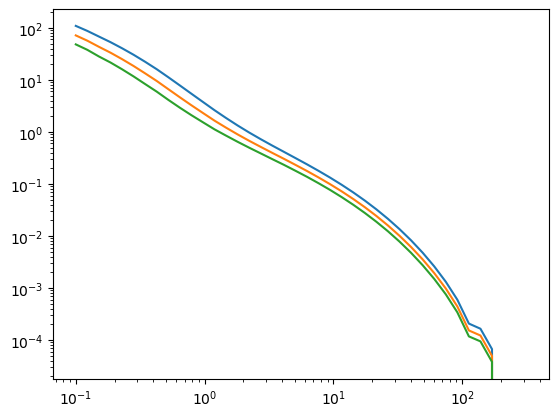

In [23]:
plt.loglog(R3d, Xi_3d[0,:])
plt.loglog(R3d, Xi_3d[100,:])
plt.loglog(R3d, Xi_3d[199,:])

In [47]:
def xi_m_bar(R, z):
    index_z=find_z(z)
    xi_r=XI_interp[index_z]
    def integrate_r3d(r):
        return r**2*xi_r(r)
    return 3/R**3*quad(integrate_r3d, 0.1, R, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


def xi_m_barbar(R, z):
    index_z=find_z(z)
    xi_r=XI_interp[index_z]
    def integrate_r3d(r):
        return r**4*xi_r(r)
    return 5/R**5*quad(integrate_r3d, 0.1, R, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [39]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

Xi_3d_bar=np.zeros((len(Zlist), len(R3d)),dtype=np.float64)
for iz in range(len(Zlist)):
    for ir in range(len(R3d)):
        Xi_3d_bar[iz][ir]=xi_m_bar(R3d[ir],Zlist[iz])

Xi_3d_bar = np.savetxt('xi3d_bar_estimator_z2_3_logrm1_p2.5.txt', Xi_3d_bar)

In [52]:
Xi_3d_bar=np.loadtxt('xi3d_bar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_bar=np.transpose(Xi_3d_bar)

XI_bar_interp=[]
for iz in range(len(Zlist)):
    XI_bar_interp.append(interpolate.interp1d(R3d, Xi_3d_bar[iz]))

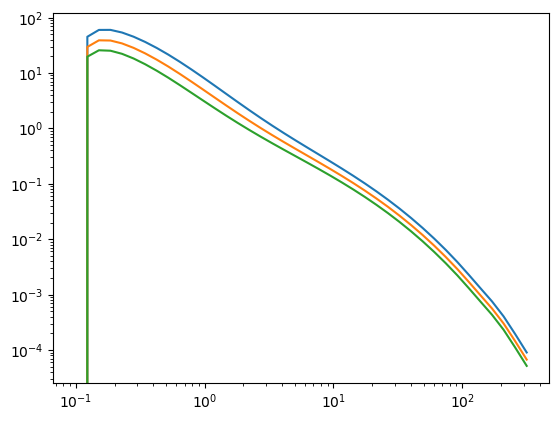

In [44]:
plt.loglog(R3d, Xi_3d_bar[0,:])
plt.loglog(R3d, Xi_3d_bar[99,:])
plt.loglog(R3d, Xi_3d_bar[199,:])

In [48]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

Xi_3d_barbar=np.zeros((len(Zlist), len(R3d)),dtype=np.float64)
for iz in range(len(Zlist)):
    for ir in range(len(R3d)):
        Xi_3d_barbar[iz][ir]=xi_m_barbar(R3d[ir],Zlist[iz])

Xi_3d_barbar = np.savetxt('xi3d_barbar_estimator_z2_3_logrm1_p2.5.txt', Xi_3d_barbar)

In [53]:
Xi_3d_barbar=np.loadtxt('xi3d_barbar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_barbar=np.transpose(Xi_3d_barbar)

XI_barbar_interp=[]
for iz in range(len(Zlist)):
    XI_barbar_interp.append(interpolate.interp1d(R3d, Xi_3d_barbar[iz]))

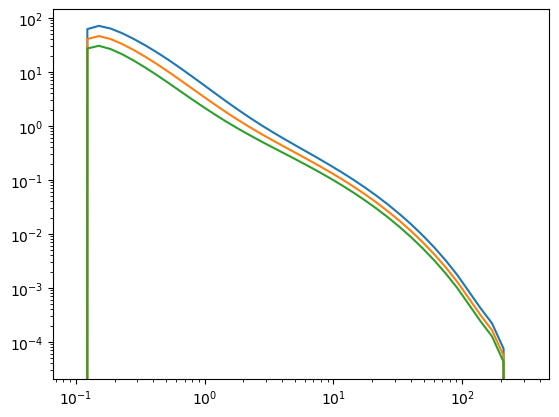

In [50]:
plt.loglog(R3d, Xi_3d_barbar[0,:])
plt.loglog(R3d, Xi_3d_barbar[99,:])
plt.loglog(R3d, Xi_3d_barbar[199,:])

!!!Note!!! First few points for xi_bar and xi_barbar cannot be trusted, because I used the pre-computed xi_r. The precise version would be using the full integral xi_m(r,z), but testing this for computing 1 single point takes about 3 - 6 min! For speed I choose to use the approximate version, which should work on large enough scales.

In [55]:
def xi_rsd(R,z,mu,beta,beta2=None):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    index_z=find_z(z) # find the best z-index for xi
    
    xi_r=XI_interp[index_z]
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_r(R)

    xi_bar_r=XI_bar_interp[index_z]
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*(xi_r(R) - xi_bar_r(R))

    xi_barbar = XI_barbar_interp[index_z]
    xi_4 = 8/35.*beta*beta2*(xi_r(R) + 5/2.*xi_bar_r(R) - 7/2.*xi_barbar(R))
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return xi_0*P_0 + xi_2*P_2 + xi_4*P_4

In [56]:
def omega_m_z(z):
    omega_m0 = 0.315
    return omega_m0*(1+z)**3/(omega_m0*(1+z)**3 + (1-omega_m0))

In [105]:
# let's choose a z, and generate xi_rsd on a grid:
rperp = np.linspace(1, 80, 100)
rpara = np.linspace(10, 50, 100)
xx,yy = np.meshgrid(rperp,rpara,indexing='xy')
R = np.sqrt(xx**2+yy**2)
mu = yy/R
z = 2.5
# let's just assume some bias b=2.5 and a simplified model for the growth rate, f = Omega_m^0.55
b_g = 2.5
beta = omega_m_z(z)**0.55/b_g
print(beta)
res = xi_rsd(R,z,mu,beta,beta2=None)

0.3892621984717692


Text(0.5, 1.0, 'zmean=2.5, beta = 0.39')

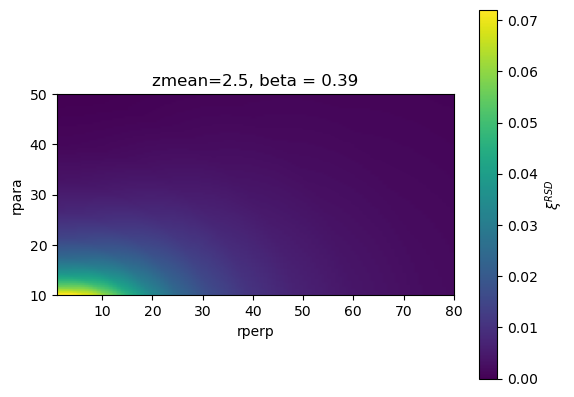

In [111]:
# make the four quadrants:
plt.imshow(res, extent=[1,80,10,50],origin="lower")
plt.colorbar(label="$\\xi^{RSD}$")
plt.xlabel("rperp")
plt.ylabel("rpara")
plt.title("zmean=2.5, beta = 0.39")

In [112]:
def mu_rsd(z1,z2,r):
    return (chi(z1)-chi(z2))/r

In [114]:
def wnotLimber_rsd(zmean, Delta_z, rp, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [132]:
def wnotLimber_rsd_theta(zmean, Delta_z, theta_arcmin, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [126]:
beta

0.3892621984717692

In [127]:
rp=5
Dz=0.025
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.2033825810767025

In [128]:
rp=20
Dz=0.025
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.4680651578952761

In [131]:
rp=5
Dz=0.05
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.127316146658506

# fit to data

In [133]:
# now let's compute this as a function of theta, then combine the theta bins:
Ndz=2
Z_20=[2.025+i*0.05 for i in range(20)]
Z_40=[2.0125+i*0.025 for i in range(40)]

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
#Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)

W_theta1030_dz025=np.zeros((Ntheta,40))
#W_theta3050_dz025=np.zeros((Ntheta,40))
W_theta1030_dz05=np.zeros((Ntheta,20))
#W_theta3050_dz05=np.zeros((Ntheta,20))

print(np.shape(W_theta1030_dz025))

(10, 40)


In [138]:
# Bias model
data=np.loadtxt('../bias_dc2.txt')
Z_bias,bias_model=data[:,0],data[:,1]
bias_law=interpolate.interp1d(Z_bias,bias_model)

In [134]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(20):
        zmean=Z_20[jdz]
        dz=0.05
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz05[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [135]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(40):
        zmean=Z_40[jdz]
        dz=0.025
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz025[itheta][jdz]=not_limb_1030
        #W_theta3050_dz025[itheta][jdz]=not_limb_3050

0
1
2
3
4
5
6
7
8
9


In [140]:
# wpp data
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
data=np.loadtxt(root+'mock0-w_pp-norsd-theta-min-10-max-30-zbin-40.txt')
Z_025,wpp_10_30_z025,err_wpp_10_30_z025=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt(root+'mock0-w_pp-norsd-theta-min-10-max-30-zbin-20.txt')
Z_05,wpp_10_30_z05,err_wpp_10_30_z05=data[:-1,0],data[:-1,1],data[:-1,2]

In [141]:
# power law for the scale weighting;
alpha=2

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=2$, no RSD')

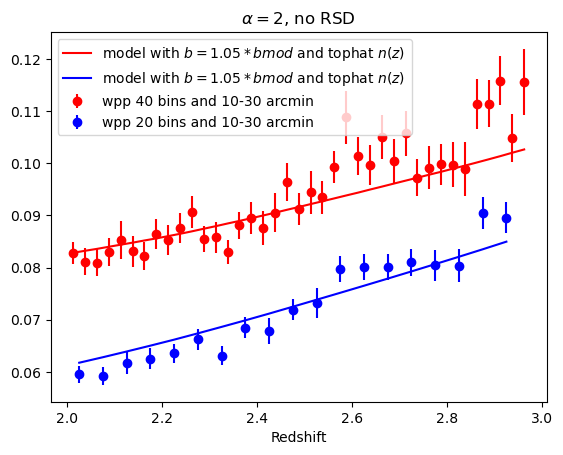

In [187]:
# mismatch in bias between model and data:
#eta_bias=0.87
eta_bias=1.05

plt.errorbar(Z_025,wpp_10_30_z025,yerr=err_wpp_10_30_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05,yerr=err_wpp_10_30_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title("$\\alpha=2$, no RSD")
#plt.savefig('test_newbias.png')

In [179]:
# now rsd:
# now let's compute this as a function of theta, then combine the theta bins:
Ndz=2
Z_20=[2.025+i*0.05 for i in range(20)]
Z_40=[2.0125+i*0.025 for i in range(40)]

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
#Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)

W_theta1030_dz025_rsd=np.zeros((Ntheta,40))
#W_theta3050_dz025=np.zeros((Ntheta,40))
W_theta1030_dz05_rsd=np.zeros((Ntheta,20))
#W_theta3050_dz05=np.zeros((Ntheta,20))

print(np.shape(W_theta1030_dz025_rsd))

(10, 40)


In [180]:
# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(19):
        zmean=Z_20[jdz]
        dz=0.05
        beta = omega_m_z(zmean)**0.55/bias_law(zmean)
        not_limb_1030=wnotLimber_rsd_theta(zmean,dz, Theta_10_30[itheta], beta)
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz05_rsd[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [183]:
# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(39):
        zmean=Z_40[jdz]
        dz=0.025
        beta = omega_m_z(zmean)**0.55/bias_law(round(zmean,4))
        not_limb_1030=wnotLimber_rsd_theta(zmean,dz, Theta_10_30[itheta], beta)
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz025_rsd[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [184]:
# power law for the scale weighting;
alpha=2

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_rsd_mean=[np.sum(W_theta1030_dz025_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_rsd_mean=[np.sum(W_theta1030_dz05_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025_rsd=Wtheta_1030_dz025_rsd_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05_rsd=Wtheta_1030_dz05_rsd_mean[:-1]*bias_law(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

In [177]:
# wpp data
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
data=np.loadtxt(root+'mock0-w_pp-theta-min-10-max-30-zbin-40.txt')
Z_025,wpp_10_30_z025_rsd,err_wpp_10_30_z025_rsd=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt(root+'mock0-w_pp-theta-min-10-max-30-zbin-20.txt')
Z_05,wpp_10_30_z05_rsd,err_wpp_10_30_z05_rsd=data[:-1,0],data[:-1,1],data[:-1,2]

Text(0.5, 1.0, '$\\alpha=2$, RSD')

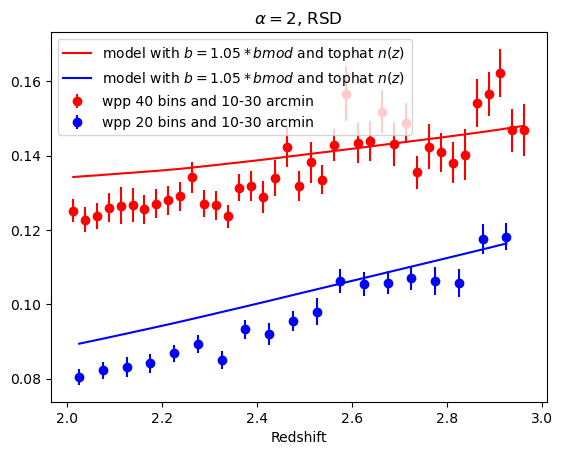

In [186]:
# mismatch in bias between model and data:
#eta_bias=0.87
eta_bias=1.05

plt.errorbar(Z_025,wpp_10_30_z025_rsd,yerr=err_wpp_10_30_z025_rsd,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05_rsd,yerr=err_wpp_10_30_z05_rsd,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025_rsd*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05_rsd*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title("$\\alpha=2$, RSD")
#plt.savefig('test_newbias.png')

Let's try some other alpha's and see what fits the best

In [228]:
# power law for the scale weighting;
alpha=0

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=0$, no RSD')

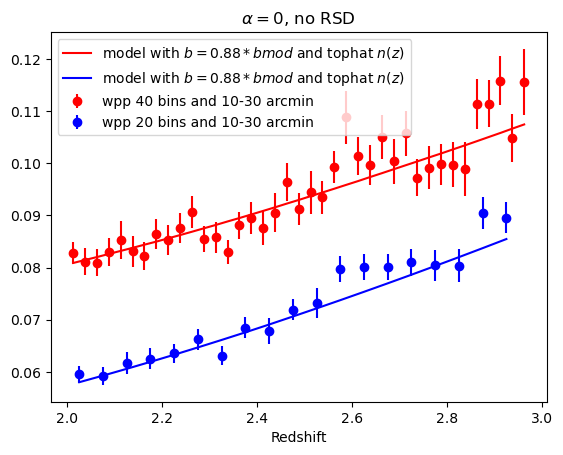

In [234]:
# mismatch in bias between model and data:
eta_bias=0.88
#eta_bias=0.91

plt.errorbar(Z_025,wpp_10_30_z025,yerr=err_wpp_10_30_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05,yerr=err_wpp_10_30_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title(f"$\\alpha={alpha}$, no RSD")
#plt.savefig('test_newbias.png')

In [235]:
# power law for the scale weighting;
#lpha=1

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_rsd_mean=[np.sum(W_theta1030_dz025_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_rsd_mean=[np.sum(W_theta1030_dz05_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025_rsd=Wtheta_1030_dz025_rsd_mean[:-1]*bias_law(Z_025)**2
Wb2_10_30_dz05_rsd=Wtheta_1030_dz05_rsd_mean[:-1]*bias_law(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=0$, RSD')

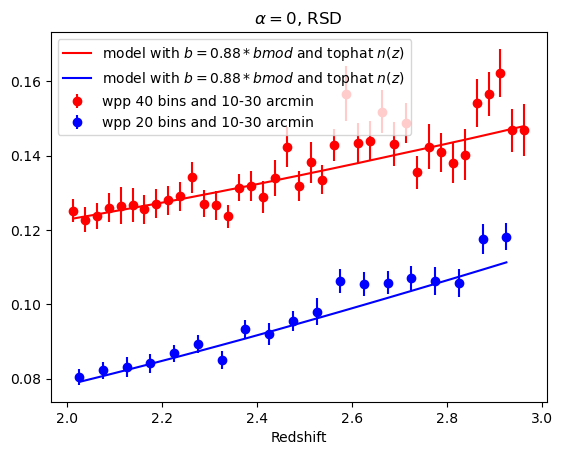

In [236]:
# mismatch in bias between model and data:
#eta_bias=0.87
#eta_bias=0.96

plt.errorbar(Z_025,wpp_10_30_z025_rsd,yerr=err_wpp_10_30_z025_rsd,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05_rsd,yerr=err_wpp_10_30_z05_rsd,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025_rsd*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05_rsd*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title(f"$\\alpha={alpha}$, RSD")
#plt.savefig('test_newbias.png')

In [237]:
! ls /pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/

mock0-w_pp-norsd-theta-min-10-max-30-zbin-10.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-20.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-40.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-5.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-50.txt
mock0-w_pp-norsd-theta-min-30-max-50-zbin-20.txt
mock0-w_pp-norsd-theta-min-30-max-50-zbin-40.txt
mock0-w_pp-theta-min-10-max-30-zbin-10.txt
mock0-w_pp-theta-min-10-max-30-zbin-20.txt
mock0-w_pp-theta-min-10-max-30-zbin-40.txt
mock0-w_pp-theta-min-10-max-30-zbin-5.txt
mock0-w_pp-theta-min-10-max-30-zbin-50.txt
mock0-w_pp-theta-min-30-max-50-zbin-20.txt
mock0-w_pp-theta-min-30-max-50-zbin-40.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-10bin-z_cosmo.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-20bin-z_cosmo.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-40bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-10bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-20bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-40bin-z_cosmo.txt
wpp-norsd-theta-10bins

In [290]:
# test combine the theta bins:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
wptheta_20bins = np.loadtxt(root + "wpp-theta-10bins-min-10-max-30-z-20bin.txt")
wptheta_40bins = np.loadtxt(root + "wpp-theta-10bins-min-10-max-30-z-40bin.txt")

wp_20bins = np.loadtxt(root + "mock0-w_pp-theta-min-10-max-30-zbin-20.txt")
wp_40bins = np.loadtxt(root + "mock0-w_pp-theta-min-10-max-30-zbin-40.txt")

In [240]:
wptheta_20bins.shape

(20, 20)

In [293]:
alpha=0
Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])

mean_wp_thetacomb_20bins = np.zeros(20)
for ii in range(20):
    denom = (Theta_10_30_edges[-1]**(alpha+1)-Theta_10_30_edges[0]**(alpha+1))/(alpha+1)
    #denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
    mean_wp_thetacomb_20bins[ii] = sum(wptheta_20bins[:10,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom

mean_wp_thetacomb_40bins = np.zeros(40)
for ii in range(40):
    mean_wp_thetacomb_40bins[ii] = sum(wptheta_40bins[:10,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/sum(Theta_10_30_bincen**alpha*dTheta_10_30)

Text(0, 0.5, 'wpp(theta, z) Combined / wpp(z)')

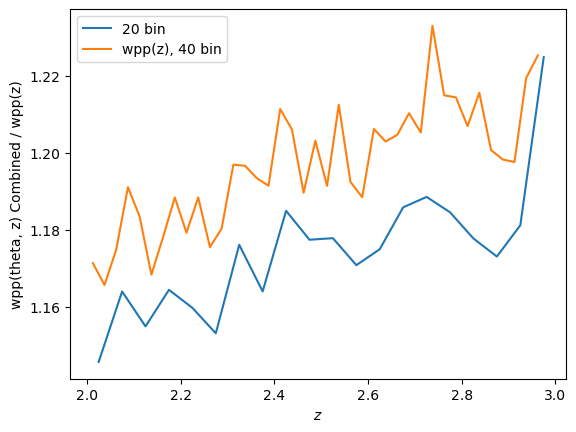

In [322]:
plt.plot(Z_20, mean_wp_thetacomb_20bins/ wp_20bins[:,1],'-',label="20 bin")
#plt.plot(wp_20bins[:,0], wp_20bins[:,1], label="Full bin")
#plt.legend()

plt.plot(Z_40[:-1], mean_wp_thetacomb_40bins[:-1]/wpp_10_30_z025_rsd,'-',label="wpp(z), 40 bin")
#plt.plot(Z_025, wpp_10_30_z025_rsd, label="Full bin")
plt.legend()
plt.xlabel("$z$")
plt.ylabel("wpp(theta, z) Combined / wpp(z)")

Text(0.5, 1.0, 'With RSD 20 bins, bias law * 1.00')

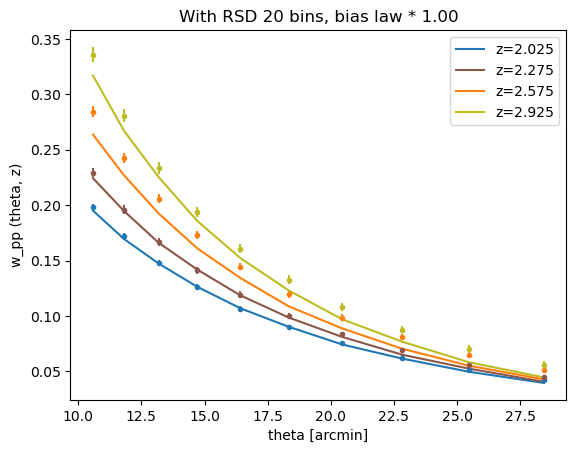

In [320]:
for ii in [0,5,11,18]:
    bg = bias_law(Z_20[ii])
    plt.plot(Theta_10_30_bincen, W_theta1030_dz05_rsd[:,ii]*bg**2,color=f'C{ii}',label=f"z={round(Z_20[ii],3)}")
    plt.errorbar(Theta_10_30_bincen, wptheta_20bins[:10,ii],yerr =wptheta_20bins[10:,ii], fmt='.',color=f'C{ii}')
plt.xlabel("theta [arcmin]")
plt.ylabel("w_pp (theta, z)")   
plt.legend()
plt.title("With RSD 20 bins, bias law * 1.00")